# Initialize

In [1]:
%matplotlib inline
import yt
import yt.fields.vector_operations
from yt.units import dimensions, kboltz, mp
import os, sys, glob, errno
import matplotlib as mpl
#mpl.use("agg")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Locator
from scipy.interpolate import spline
import operator
import h5py
sys.path.append("../")
import magnolia


mu = 0.588
mu_e = 1.14
gamma = 5/3

a=0

def get_units(L):
    temp_str = str(L[-1:])
    k = temp_str.rfind("]") + 2
    return temp_str[k:]

def density(filename,groupname):
    return yt.YTArray.from_hdf5(filename, dataset_name="/%s/density_mean"%groupname)[a:]  

def kT(filename,groupname):
    return yt.YTArray.from_hdf5(filename, dataset_name="/%s/kT_mean"%groupname)[a:] 

# radial 
def velocity_r_variance(filename,groupname):
    v_r_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)[a:] 
    return v_r_stddev**2

# tangential
def velocity_t_variance(filename,groupname):
    v_theta_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)[a:] 
    v_phi_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)[a:]  
    return v_theta_stddev**2+v_phi_stddev**2

# filename is HDF5 file, groupname is 0500_profiles
def velocity_variance(filename,groupname):
    #v_r_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_stddev"%groupname)
    #v_t_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_stddev"%groupname)
    #v_p_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_stddev"%groupname)    
    return velocity_r_variance(filename,groupname)+velocity_t_variance(filename,groupname)

# filename is HDF5 file, groupname is 0500_profiles
def mag_field_variance(filename,groupname):
    B_r_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_stddev"%groupname)[a:] 
    B_t_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_stddev"%groupname)[a:] 
    B_p_stddev=yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_stddev"%groupname)[a:]     
    return B_r_stddev**2+B_t_stddev**2+B_p_stddev**2

# mean squared
def velocity_mean_sq(filename,groupname):
    v_r_mean=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_radius_mean"%groupname)[a:] 
    v_t_mean=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_theta_mean"%groupname)[a:] 
    v_p_mean=yt.YTArray.from_hdf5(filename, dataset_name="/%s/velocity_spherical_phi_mean"%groupname)[a:]     
    return v_r_mean**2+v_t_mean**2+v_p_mean**2

# mean squared
def mag_field_mean_sq(filename,groupname):
    B_r_mean=yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_radius_mean"%groupname)[a:] 
    B_t_mean=yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_theta_mean"%groupname)[a:] 
    B_p_mean=yt.YTArray.from_hdf5(filename, dataset_name="/%s/magnetic_field_spherical_phi_mean"%groupname)[a:]     
    return B_r_mean**2+B_t_mean**2+B_p_mean**2

# sound speed sq
def c_s_sq(filename,groupname):
    return gamma*kT(filename,groupname)/(mu*mp)

# Alfven speed sq
def v_A_sq(filename,groupname):
    return (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))/(4*np.pi*density(filename,groupname))
    
def n_e(filename,groupname):
    return density(filename,groupname)/(mu_e*mp)
    
def S(filename,groupname):
    return kT(filename,groupname)/(n_e(filename,groupname))**(2/3)

def hopefully_constant(filename,groupname):
    B_sq = (mag_field_variance(filename,groupname)+mag_field_mean_sq(filename,groupname))
    return B_sq/(density(filename,groupname))**(4/3)

../magnolia/derived_field_definitions.py:14: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/data/mimir/jzuhone/miniconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/mimir/jzuhone/miniconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, i

# Density Plots

/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

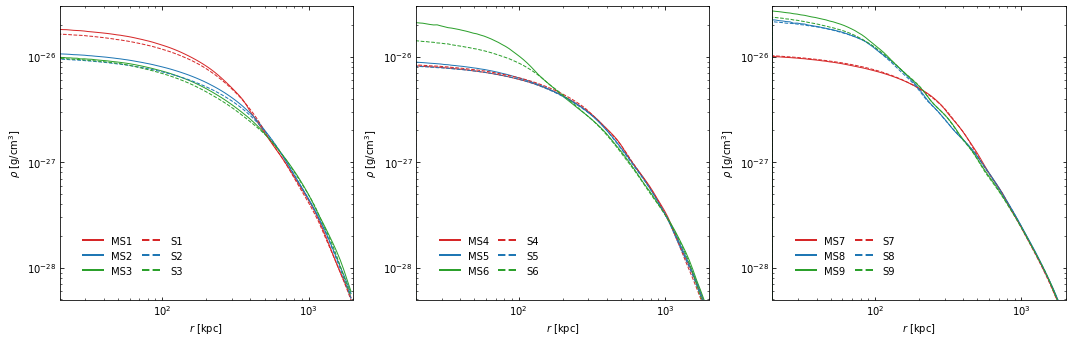

In [2]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "../processed-data/1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "../processed-data/1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "../processed-data/1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "../processed-data/1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "../processed-data/1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "../processed-data/1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "../processed-data/1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "../processed-data/1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "../processed-data/1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "../processed-data/1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "../processed-data/1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "../processed-data/1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "../processed-data/1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "../processed-data/1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "../processed-data/1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "../processed-data/1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "../processed-data/1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "../processed-data/1to10_b1"+"_no_mag.hdf5"

a=00

radius = yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=5e-29
ylim2=3e-26
num=(np.log10(xlim2)-np.log10(xlim1))/(np.log10(ylim2)-np.log10(ylim1))

ax1 = plt.subplot(131, aspect=num)
ax2 = plt.subplot(132, aspect=num)
ax3 = plt.subplot(133, aspect=num)
# #ax1.tick_params(direction='in',top='on',right='on')

# ax1 = plt.subplot(131)
# ax2 = plt.subplot(132)
# ax3 = plt.subplot(133)


axes = [ax1, ax2, ax3]

# print(radius, len(radius))
# print(density(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), len(density(SIM_TYPE11_no_mag,"profiles_0500")))

# magnetic
line_11_mag, =ax1.plot(radius, density(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS1")
line_12_mag, =ax1.plot(radius, density(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS2")
line_13_mag, =ax1.plot(radius, density(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS3")
line_21_mag, =ax2.plot(radius, density(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS4")
line_22_mag, =ax2.plot(radius, density(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS5")
line_23_mag, =ax2.plot(radius, density(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="MS6")
line_31_mag, =ax3.plot(radius, density(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS7")
line_32_mag, =ax3.plot(radius, density(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS8")
line_33_mag, =ax3.plot(radius, density(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS9")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, density(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S1")
line_12_no_mag, =ax1.plot(radius, density(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S2")
line_13_no_mag, =ax1.plot(radius, density(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S3")
line_21_no_mag, =ax2.plot(radius, density(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S4")
line_22_no_mag, =ax2.plot(radius, density(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S5")
line_23_no_mag, =ax2.plot(radius, density(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S6")
line_31_no_mag, =ax3.plot(radius, density(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S7")
line_32_no_mag, =ax3.plot(radius, density(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S8")
line_33_no_mag, =ax3.plot(radius, density(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S9")

leg1 = ax1.legend(bbox_to_anchor=(0.05, 0.05), handles=[line_11_mag,line_12_mag,line_13_mag], loc=3)
ax1.add_artist(leg1)
leg2 = ax1.legend(bbox_to_anchor=(0.25, 0.05), handles=[line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=3)
leg3 = ax2.legend(bbox_to_anchor=(0.05, 0.05), handles=[line_21_mag,line_22_mag,line_23_mag], loc=3)
ax2.add_artist(leg3)
leg4 = ax2.legend(bbox_to_anchor=(0.25, 0.05), handles=[line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=3)
leg5 = ax3.legend(bbox_to_anchor=(0.05, 0.05), handles=[line_31_mag,line_32_mag,line_33_mag], loc=3)
ax3.add_artist(leg5)
leg6 = ax3.legend(bbox_to_anchor=(0.25, 0.05), handles=[line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=3)


for leg in [leg1,leg2,leg3,leg4,leg5,leg6]:
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel(r"$\rho$ [g/cm$^3$]") #% get_units(density(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
plt.tight_layout()
plt.savefig('density.pdf',bbox_inches='tight')
plt.show()

# Entropy Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1372: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

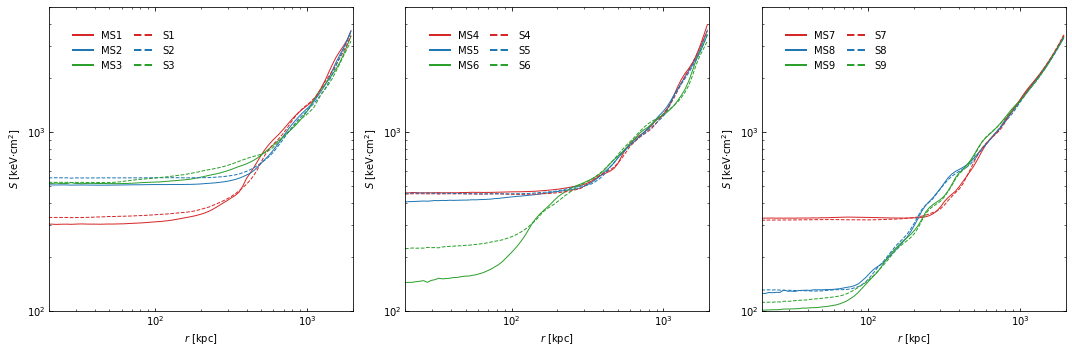

In [3]:
SIM_TYPE11 = "1to1_b0"
SIM_TYPE12 = "1to1_b0.5"
SIM_TYPE13 = "1to1_b1"
SIM_TYPE21 = "1to3_b0"
SIM_TYPE22 = "1to3_b0.5"
SIM_TYPE23 = "1to3_b1"
SIM_TYPE31 = "1to10_b0"
SIM_TYPE32 = "1to10_b0.5"
SIM_TYPE33 = "1to10_b1"

SIM_TYPE11_mag = "../processed-data/1to1_b0"+"_mag.hdf5"
SIM_TYPE12_mag = "../processed-data/1to1_b0.5"+"_mag.hdf5"
SIM_TYPE13_mag = "../processed-data/1to1_b1"+"_mag.hdf5"

SIM_TYPE21_mag = "../processed-data/1to3_b0"+"_mag.hdf5"
SIM_TYPE22_mag = "../processed-data/1to3_b0.5"+"_mag.hdf5"
SIM_TYPE23_mag = "../processed-data/1to3_b1"+"_mag.hdf5"

SIM_TYPE31_mag = "../processed-data/1to10_b0"+"_mag.hdf5"
SIM_TYPE32_mag = "../processed-data/1to10_b0.5"+"_mag.hdf5"
SIM_TYPE33_mag = "../processed-data/1to10_b1"+"_mag.hdf5"

SIM_TYPE11_no_mag = "../processed-data/1to1_b0"+"_no_mag.hdf5"
SIM_TYPE12_no_mag = "../processed-data/1to1_b0.5"+"_no_mag.hdf5"
SIM_TYPE13_no_mag = "../processed-data/1to1_b1"+"_no_mag.hdf5"

SIM_TYPE21_no_mag = "../processed-data/1to3_b0"+"_no_mag.hdf5"
SIM_TYPE22_no_mag = "../processed-data/1to3_b0.5"+"_no_mag.hdf5"
SIM_TYPE23_no_mag = "../processed-data/1to3_b1"+"_no_mag.hdf5"

SIM_TYPE31_no_mag = "../processed-data/1to10_b0"+"_no_mag.hdf5"
SIM_TYPE32_no_mag = "../processed-data/1to10_b0.5"+"_no_mag.hdf5"
SIM_TYPE33_no_mag = "../processed-data/1to10_b1"+"_no_mag.hdf5"



radius = yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e2
ylim2=5e3
num=(np.log10(xlim2)-np.log10(xlim1))/(np.log10(ylim2)-np.log10(ylim1))

ax1 = plt.subplot(131, aspect=num)
ax2 = plt.subplot(132, aspect=num)
ax3 = plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, S(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS1")
line_12_mag, =ax1.plot(radius, S(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS2")
line_13_mag, =ax1.plot(radius, S(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS3")
line_21_mag, =ax2.plot(radius, S(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS4")
line_22_mag, =ax2.plot(radius, S(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS5")
line_23_mag, =ax2.plot(radius, S(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="MS6")
line_31_mag, =ax3.plot(radius, S(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS7")
line_32_mag, =ax3.plot(radius, S(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS8")
line_33_mag, =ax3.plot(radius, S(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS9")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, S(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S1")
line_12_no_mag, =ax1.plot(radius, S(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S2")
line_13_no_mag, =ax1.plot(radius, S(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S3")
line_21_no_mag, =ax2.plot(radius, S(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S4")
line_22_no_mag, =ax2.plot(radius, S(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S5")
line_23_no_mag, =ax2.plot(radius, S(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S6")
line_31_no_mag, =ax3.plot(radius, S(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S7")
line_32_no_mag, =ax3.plot(radius, S(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S8")
line_33_no_mag, =ax3.plot(radius, S(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S9")

leg1 = ax1.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
ax1.add_artist(leg1)
leg2 = ax1.legend(bbox_to_anchor=(0.25, 0.95), handles=[line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
leg3 = ax2.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)
ax2.add_artist(leg3)
leg4 = ax2.legend(bbox_to_anchor=(0.25, 0.95), handles=[line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=2)
leg5 = ax3.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_31_mag,line_32_mag,line_33_mag], loc=2)
ax3.add_artist(leg5)
leg6 = ax3.legend(bbox_to_anchor=(0.25, 0.95), handles=[line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=2)


for leg in [leg1,leg2,leg3,leg4,leg5,leg6]:
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)



#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')
    
    plot_ax.set_ylabel("$S$ [keV$\cdot$cm$^2$]") #% get_units(S(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
plt.tight_layout()
plt.savefig('entropy.pdf',bbox_inches='tight')
plt.show()

# Velocity Dispersion to Sound Speed Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1372: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

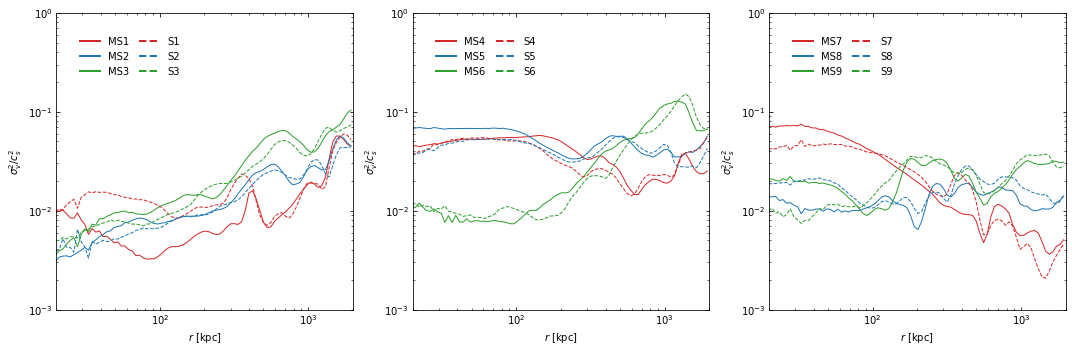

In [4]:


radius = yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-3
ylim2=1e0
num=(np.log10(xlim2)-np.log10(xlim1))/(np.log10(ylim2)-np.log10(ylim1))

ax1 = plt.subplot(131, aspect=num)
ax2 = plt.subplot(132, aspect=num)
ax3 = plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS1")
line_12_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS2")
line_13_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS3")
line_21_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS4")
line_22_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS5")
line_23_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/c_s_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="MS6")
line_31_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS7")
line_32_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS8")
line_33_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS9")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S1")
line_12_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S2")
line_13_no_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S3")
line_21_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S4")
line_22_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S5")
line_23_no_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S6")
line_31_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S7")
line_32_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S8")
line_33_no_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S9")

leg1 = ax1.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
ax1.add_artist(leg1)
leg2 = ax1.legend(bbox_to_anchor=(0.25, 0.95), handles=[line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=2)
leg3 = ax2.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)
ax2.add_artist(leg3)
leg4 = ax2.legend(bbox_to_anchor=(0.25, 0.95), handles=[line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=2)
leg5 = ax3.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_31_mag,line_32_mag,line_33_mag], loc=2)
ax3.add_artist(leg5)
leg6 = ax3.legend(bbox_to_anchor=(0.25, 0.95), handles=[line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=2)


for leg in [leg1,leg2,leg3,leg4,leg5,leg6]:
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v^2/c_s^2$") #% get_units(velocity_variance(SIM_TYPE11_no_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_no_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
plt.tight_layout()
plt.savefig('sigma_cs.pdf',bbox_inches='tight')
plt.show()

# Alfven Speed to Sound Speed Plots

/home/jzuhone/Source/yt/yt/units/yt_array.py:1372: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

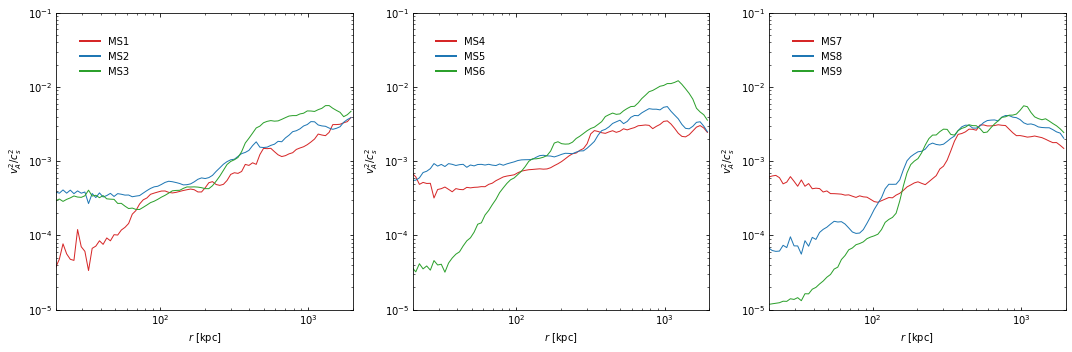

In [5]:


radius = yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e-5
ylim2=1e-1
num=(np.log10(xlim2)-np.log10(xlim1))/(np.log10(ylim2)-np.log10(ylim1))

ax1 = plt.subplot(131, aspect=num)
ax2 = plt.subplot(132, aspect=num)
ax3 = plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS1")
line_12_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS2")
line_13_mag, =ax1.plot(radius, v_A_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS3")
line_21_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS4")
line_22_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS5")
line_23_mag, =ax2.plot(radius, v_A_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/c_s_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="MS6")
line_31_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS7")
line_32_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS8")
line_33_mag, =ax3.plot(radius, v_A_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/c_s_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS9")

leg1 = ax1.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_11_mag,line_12_mag,line_13_mag], loc=2)
leg3 = ax2.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_21_mag,line_22_mag,line_23_mag], loc=2)
leg5 = ax3.legend(bbox_to_anchor=(0.05, 0.95), handles=[line_31_mag,line_32_mag,line_33_mag], loc=2)


for leg in [leg1,leg3,leg5]:
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$v_A^2/c_s^2$") #% get_units(v_A_sq(SIM_TYPE11_mag,"profiles_0500")/c_s_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
plt.tight_layout()
plt.savefig('vA_cs.pdf',bbox_inches='tight')
plt.show()

# Velocity Dispersion to Alfven Speed

/home/jzuhone/Source/yt/yt/units/yt_array.py:1372: RuntimeWarning: invalid value encountered in true_divide
  out=out, **kwargs)
/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

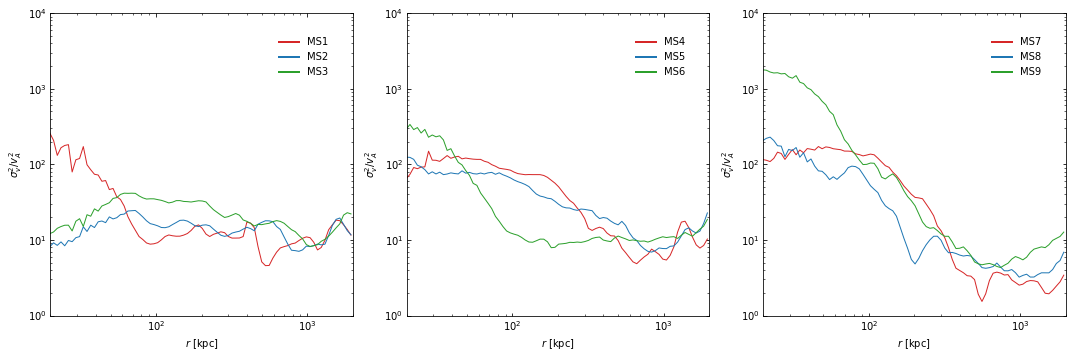

In [6]:



radius = yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=1e0
ylim2=1e4
num=(np.log10(xlim2)-np.log10(xlim1))/(np.log10(ylim2)-np.log10(ylim1))

ax1 = plt.subplot(131, aspect=num)
ax2 = plt.subplot(132, aspect=num)
ax3 = plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS1")
line_12_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS2")
line_13_mag, =ax1.plot(radius, velocity_variance(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS3")
line_21_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS4")
line_22_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS5")
line_23_mag, =ax2.plot(radius, velocity_variance(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix")/v_A_sq(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="MS6")
line_31_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS7")
line_32_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS8")
line_33_mag, =ax3.plot(radius, velocity_variance(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix")/v_A_sq(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS9")

leg1 = ax1.legend(bbox_to_anchor=(0.95, 0.95), handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
leg3 = ax2.legend(bbox_to_anchor=(0.95, 0.95), handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
leg5 = ax3.legend(bbox_to_anchor=(0.95, 0.95), handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)


for leg in [leg1,leg3,leg5]:
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$\sigma_v^2/v_A^2$") #% get_units(velocity_variance(SIM_TYPE11_mag,"profiles_0500")/v_A_sq(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
plt.tight_layout()
plt.savefig('sigma_vA.pdf',bbox_inches='tight')
plt.show()

# kT Plots

/data/mimir/jzuhone/miniconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<Figure size 432x288 with 0 Axes>

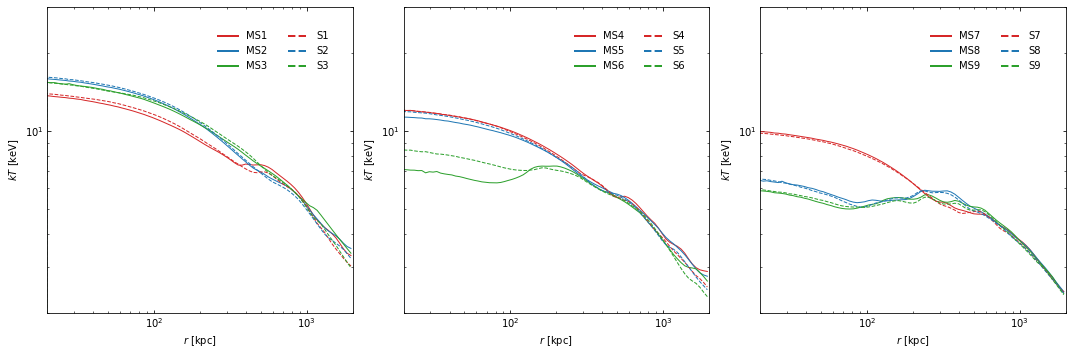

In [7]:


radius = yt.YTArray.from_hdf5(SIM_TYPE11_mag, dataset_name="/%s/radius"%"profiles_0500_gpot_afterfix")[a:].in_units('kpc')

plt.close('all')
f = plt.figure()
plt.figure(figsize=(15, 20))
#plt.subplots_adjust(hspace=0.001)

xlim1=2e1
xlim2=2e3
ylim1=2e0
ylim2=3e1
num=(np.log10(xlim2)-np.log10(xlim1))/(np.log10(ylim2)-np.log10(ylim1))

ax1 = plt.subplot(131, aspect=num)
ax2 = plt.subplot(132, aspect=num)
ax3 = plt.subplot(133, aspect=num)
#ax1.tick_params(direction='in',top='on',right='on')


axes = [ax1, ax2, ax3]

# magnetic
line_11_mag, =ax1.plot(radius, kT(SIM_TYPE11_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS1")
line_12_mag, =ax1.plot(radius, kT(SIM_TYPE12_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS2")
line_13_mag, =ax1.plot(radius, kT(SIM_TYPE13_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS3")
line_21_mag, =ax2.plot(radius, kT(SIM_TYPE21_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS4")
line_22_mag, =ax2.plot(radius, kT(SIM_TYPE22_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS5")
line_23_mag, =ax2.plot(radius, kT(SIM_TYPE23_mag,"profiles_0450_gpot_afterfix"), 'C2', lw=1, label="MS6")
line_31_mag, =ax3.plot(radius, kT(SIM_TYPE31_mag,"profiles_0500_gpot_afterfix"), 'C3', lw=1, label="MS7")
line_32_mag, =ax3.plot(radius, kT(SIM_TYPE32_mag,"profiles_0500_gpot_afterfix"), 'C0', lw=1, label="MS8")
line_33_mag, =ax3.plot(radius, kT(SIM_TYPE33_mag,"profiles_0500_gpot_afterfix"), 'C2', lw=1, label="MS9")

# non-magnetic
line_11_no_mag, =ax1.plot(radius, kT(SIM_TYPE11_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S1")
line_12_no_mag, =ax1.plot(radius, kT(SIM_TYPE12_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S2")
line_13_no_mag, =ax1.plot(radius, kT(SIM_TYPE13_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S3")
line_21_no_mag, =ax2.plot(radius, kT(SIM_TYPE21_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S4")
line_22_no_mag, =ax2.plot(radius, kT(SIM_TYPE22_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S5")
line_23_no_mag, =ax2.plot(radius, kT(SIM_TYPE23_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S6")
line_31_no_mag, =ax3.plot(radius, kT(SIM_TYPE31_no_mag,"profiles_0500_gpot_afterfix"), 'C3--', lw=1, label="S7")
line_32_no_mag, =ax3.plot(radius, kT(SIM_TYPE32_no_mag,"profiles_0500_gpot_afterfix"), 'C0--', lw=1, label="S8")
line_33_no_mag, =ax3.plot(radius, kT(SIM_TYPE33_no_mag,"profiles_0500_gpot_afterfix"), 'C2--', lw=1, label="S9")

leg1 = ax1.legend(bbox_to_anchor=(0.75, 0.95), handles=[line_11_mag,line_12_mag,line_13_mag], loc=1)
ax1.add_artist(leg1)
leg2 = ax1.legend(bbox_to_anchor=(0.95, 0.95), handles=[line_11_no_mag,line_12_no_mag,line_13_no_mag], loc=1)
leg3 = ax2.legend(bbox_to_anchor=(0.75, 0.95), handles=[line_21_mag,line_22_mag,line_23_mag], loc=1)
ax2.add_artist(leg3)
leg4 = ax2.legend(bbox_to_anchor=(0.95, 0.95), handles=[line_21_no_mag,line_22_no_mag,line_23_no_mag], loc=1)
leg5 = ax3.legend(bbox_to_anchor=(0.75, 0.95), handles=[line_31_mag,line_32_mag,line_33_mag], loc=1)
ax3.add_artist(leg5)
leg6 = ax3.legend(bbox_to_anchor=(0.95, 0.95), handles=[line_31_no_mag,line_32_no_mag,line_33_no_mag], loc=1)


for leg in [leg1,leg2,leg3,leg4,leg5,leg6]:
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)
#format axes
for plot_ax in axes:
    plot_ax.tick_params(axis='both',
                    which='both',
                    direction='in',
                    bottom='on',
                    top='on',
                    left='on',
                    right='on')

    plot_ax.set_ylabel("$kT$ [keV]") #% get_units(kT(SIM_TYPE11_mag,"profiles_0500")))

    plot_ax.set_xscale('log')
    plot_ax.set_yscale('log')
    plot_ax.set_xlim(xlim1,xlim2)
    plot_ax.set_ylim(ylim1,ylim2)

    plot_ax.set_xlabel("$r$ [kpc]")

    #plot_ax.set_xlim(0.0, 10000.0)
#ax1.set_ylabel("testLABEL")
#ax1.set_title('Time Series (%s)')
plt.tight_layout()
plt.savefig('kT.pdf',bbox_inches='tight')
plt.show()